<a href="https://colab.research.google.com/github/Van314159/RL/blob/main/Policy_gradient_Method_A3C_with_GAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn Book "Grokking RL"
-2025-06-23

Add GAE to Asynchronous Advantage Actor-Critic (A3C)—on the CartPole-v1 environment from OpenAI Gym.

In [3]:
import numpy as np
import gymnasium as gym
from gym import spaces
import random
import matplotlib.pyplot as plt
from statistics import mean # For mean reward logging
import pickle # For saving/loading the best episode trajectory
from collections import deque
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical

In [4]:
class FCDAP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32),
                 init_std = 0.01, activation = nn.ReLU()):
        super().__init__()

        layers = []
        dims = [input_dim] + list(hidden_dims)
        self.hidden_dims = hidden_dims
        self.init_std = init_std


        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation)
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.model = nn.Sequential(*layers)
        self._init_weights(std=init_std)

    def _init_weights(self, std):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=std)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x, dtype=torch.float32).to(device)

        if x.dim() == 1:
            x = x.unsqueeze(0)

        return self.model(x)

    def full_pass(self, state):

        logits = self.forward(state) # generate prob list over action.
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)

        with torch.no_grad():
            greedy_action = torch.argmax(logits, dim=-1)
        is_exploratory = (action != greedy_action).item()

        return action.item(), is_exploratory, log_prob, entropy

    def select_action(self, state):
        # helper function for when we only need smapled action
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()

    def select_greedy_action(self, state):
        # Just select the action with maximum prob.
        logits = self.forward(state)
        return torch.argmax(logits, dim=-1).item()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import matplotlib.pylab as pylab
from IPython.display import display
from IPython.display import HTML

plt.style.use('default')

def plot_learning_curve(xvals, yvals, label='Reward', title='Training Progress'):
    plt.plot(xvals, yvals, label=label, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [6]:
# Value neural network
class FCV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32,32), activation = nn.ReLU()):
        super().__init__()
        self.activation = activation
        layers = []
        dims = [input_dim] + list(hidden_dims)
        self.hidden_dims = hidden_dims

        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation)
        layers.append(nn.Linear(hidden_dims[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x, dtype=torch.float32).to(device)

        if x.dim() == 1:
            x = x.unsqueeze(0)

        return self.model(x)


## A3C: Parallel policy updates. Introduce Ensemble average.

In [9]:
import threading

class GlobalA3C:
    def __init__(self, policy_net: FCDAP, value_net: FCV, lr_policy, lr_value):

        self.policy_net = policy_net.to(device)
        self.value_net = value_net.to(device)

        # Make global networks share memory for multi-threading
        self.policy_net.share_memory()
        self.value_net.share_memory()

        self.optimizer_policy = optim.Adam(self.policy_net.parameters(), lr=lr_policy)
        self.optimizer_value = optim.Adam(self.value_net.parameters(), lr=lr_value)

        # Global counters/trackers
        self.global_episode = 0
        self.global_max_reward = -np.inf
        self.lock = threading.Lock() # For protecting global updates and counters
        self.episode_rewards_deque = deque(maxlen=100) # Global reward tracking
        self.training_complete = threading.Event() # Event to signal termination

### A3C with Debug
The first version is found to not learn at all. Using the debug mode, we identitfy that the local gradient is not passed to the global net. This problem is now fixed.

In [25]:
# With Debug mode

# @title
# --- Worker Thread Class ---
class Worker_GAE(threading.Thread):
    def __init__(self, worker_id, global_a3c: GlobalA3C, env:gym.Env, gamma, entropy_beta,
                 n_steps, max_grad_norm_policy, max_grad_norm_value, max_episodes_per_worker,
                 num_episodes: int = 1000, print_interval: int = 50,
                 debug_mode: bool = False,
                 gae_lambda: float = 1.0):

        super().__init__()
        self.worker_id = worker_id
        self.global_a3c = global_a3c
        self.env = env
        self.gamma = gamma
        self.entropy_beta = entropy_beta
        self.n_steps = n_steps
        self.max_grad_norm_policy = max_grad_norm_policy
        self.max_grad_norm_value = max_grad_norm_value
        self.max_episodes_per_worker = max_episodes_per_worker
        self.num_episodes = num_episodes
        self.print_interval = print_interval
        self.debug_mode = debug_mode
        self.gae_lambda = gae_lambda

        # Get architecture details from the global network instances
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.n
        policy_hidden_dims = self.global_a3c.policy_net.hidden_dims
        policy_init_std = self.global_a3c.policy_net.init_std
        value_hidden_dims = self.global_a3c.value_net.hidden_dims


        # Local networks for this worker
        self.local_policy_net = FCDAP(
            input_dim=state_dim,
            output_dim=action_dim,
            hidden_dims=policy_hidden_dims,
            init_std=policy_init_std
        ).to(device)
        self.local_value_net = FCV(
            input_dim=state_dim,
            hidden_dims=value_hidden_dims
        ).to(device)

        # Buffers for collecting n_steps experiences
        self.states = []
        self.actions = [] # Not directly used for loss, but useful for debugging
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.entropies = []

    def sync_local_networks(self):
        self.local_policy_net.load_state_dict(self.global_a3c.policy_net.state_dict())
        self.local_value_net.load_state_dict(self.global_a3c.value_net.state_dict())

    def _calculate_gae(self, rewards, values, next_state_value_detached, gamma, gae_lambda):
        """
        Calculates GAE advantages and corresponding returns.
        Args:
            rewards (list/tensor): List of rewards from the trajectory segment.
            values (list/tensor): List of predicted values V(s_t) from the trajectory segment.
                                 These should be detached from the graph.
            next_state_value_detached (torch.Tensor): Detached V(s_final_state_in_segment).
        Returns:
            torch.Tensor: GAE advantages.
            torch.Tensor: GAE returns (target for value function loss).
        """
        gae_advantages = []
        returns = [] # Store returns (targets for value function)
        gae = 0.0

        # Iterate backwards through the collected segment
        # rewards[i], values[i] correspond to time step t=i
        # next_value_t will be V(s_{t+1})
        for i in reversed(range(len(rewards))):
            reward = rewards[i]
            current_value = values[i]

            # Determine the value of the next state
            if i == len(rewards) - 1:
                # If this is the last step in the collected segment,
                # the next state value comes from the network's prediction for the actual next_state
                next_value = next_state_value_detached
            else:
                # Otherwise, the next state value is from the collected values in the segment
                next_value = values[i+1]

            # Calculate TD error (delta_t)
            delta = reward + gamma * next_value - current_value

            # Recursively calculate GAE advantage
            gae = delta + gamma * gae_lambda * gae
            gae_advantages.insert(0, gae) # Insert at beginning to maintain forward chronological order

            # Calculate the target for the value function (V_t + A_t_GAE)
            # This is equivalent to an n-step return where n is effectively chosen by lambda
            returns.insert(0, gae + current_value) # Insert at beginning

        return torch.tensor(gae_advantages, dtype=torch.float32).to(device), \
               torch.tensor(returns, dtype=torch.float32).to(device)

    def calculate_n_step_returns_and_advantages(self, next_state_value):
        # Detach values to ensure they are fixed targets and gradients don't flow through them
        # when calculating advantages and returns
        detached_values = [v.detach() for v in self.values]
        next_state_value_detached = next_state_value.detach()

        # Call the new helper function for GAE
        advantages_gae, gae_returns = self._calculate_gae(
            self.rewards,
            detached_values,
            next_state_value_detached,
            self.gamma,
            self.gae_lambda
        )

        # The function now returns the GAE-calculated advantages and the GAE-calculated returns
        return gae_returns, advantages_gae

    def update_global_networks(self, n_step_returns, advantages):
        # Prepare tensors from collected data
        log_probs_tensor = torch.cat(self.log_probs)
        entropies_tensor = torch.cat(self.entropies)
        predicted_values_tensor = torch.cat(self.values) # These are from local_value_net, but we re-predict for the loss
        if predicted_values_tensor.ndim == 2 and predicted_values_tensor.shape[1] == 1:
            predicted_values_tensor = predicted_values_tensor.squeeze(-1) # Convert [N, 1] to [N]

        # Calculate losses
        # Value loss uses GAE_returns as target
        value_loss = F.mse_loss(predicted_values_tensor, n_step_returns)
        # Policy loss uses GAE_advantages
        policy_loss = - (log_probs_tensor * advantages.squeeze(-1)).sum() - self.entropy_beta * entropies_tensor.sum()

        # --- Step 1: Compute gradients on LOCAL networks ---
        # Zero gradients for local networks BEFORE backward pass
        self.local_policy_net.zero_grad()
        self.local_value_net.zero_grad()

        # Combine losses for a single backward pass (often cleaner)
        # You might want to weigh value_loss, e.g., total_loss = policy_loss + 0.5 * value_loss
        total_loss = policy_loss + value_loss

        # Compute gradients for LOCAL networks
        total_loss.backward()
        # After this, self.local_policy_net.parameters().grad and self.local_value_net.parameters().grad
        # will contain the computed gradients.


        with self.global_a3c.lock:
            # --- DEBUGGING: Check Policy Network Updates ---
            # Get a parameter before the update (e.g., the weight of the first linear layer)
            # Use .data to get the raw tensor and .clone() to ensure you have a copy, not a view
            if self.debug_mode:
                policy_global_param_before = self.global_a3c.policy_net.model[0].weight.data.clone()

            self.global_a3c.optimizer_policy.zero_grad()
            self.global_a3c.optimizer_value.zero_grad()


            # Transfer (accumulate) gradients from local to global networks
            # This iterates through corresponding parameters and copies local_grad to global_grad
            for global_param, local_param in zip(self.global_a3c.policy_net.parameters(), self.local_policy_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # --- DEBUGGING: Check Global Policy Gradients AFTER accumulation ---
            if self.debug_mode:
                policy_global_grad = self.global_a3c.policy_net.model[0].weight.grad
                if policy_global_grad is None:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad is still None AFTER transfer! (Issue in transfer loop?)")
                elif policy_global_grad.norm().item() == 0.0:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad is all zeros AFTER transfer! (Loss problem or very small grads)")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad Norm (after transfer): {policy_global_grad.norm().item():.6f}")


            # Now, clip the gradients on the GLOBAL policy network's parameters
            torch.nn.utils.clip_grad_norm_(self.global_a3c.policy_net.parameters(), self.max_grad_norm_policy)

            # Perform the optimization step on the GLOBAL policy network
            self.global_a3c.optimizer_policy.step()

            # --- DEBUGGING: Capture Global Policy param AFTER update ---
            if self.debug_mode:
                policy_global_param_after = self.global_a3c.policy_net.model[0].weight.data.clone()
                if torch.equal(policy_global_param_before, policy_global_param_after):
                    print(f"*** CRITICAL DEBUG: Worker {self.worker_id} Global Policy network parameters DID NOT change! (Optimizer step failed?) ***")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy network parameters CHANGED. (Policy norm diff: {(policy_global_param_before - policy_global_param_after).norm().item():.6e})")

            # --- DEBUGGING: Capture Global Value param BEFORE update ---
            if self.debug_mode:
                value_global_param_before = self.global_a3c.value_net.model[0].weight.data.clone()

            # Transfer gradients from local to global value network
            for global_param, local_param in zip(self.global_a3c.value_net.parameters(), self.local_value_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # Transfer (accumulate) gradients from local to global value network
            for global_param, local_param in zip(self.global_a3c.value_net.parameters(), self.local_value_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # --- DEBUGGING: Check Global Value Gradients AFTER accumulation ---
            if self.debug_mode:
                value_global_grad = self.global_a3c.value_net.model[0].weight.grad
                if value_global_grad is None:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad is still None AFTER transfer! (Issue in transfer loop?)")
                elif value_global_grad.norm().item() == 0.0:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad is all zeros AFTER transfer! (Loss problem or very small grads)")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad Norm (after transfer): {value_global_grad.norm().item():.6f}")

            torch.nn.utils.clip_grad_norm_(self.global_a3c.value_net.parameters(), self.max_grad_norm_value)
            self.global_a3c.optimizer_value.step()

            # --- DEBUGGING: Capture Global Value param AFTER update ---
            if self.debug_mode:
                value_global_param_after = self.global_a3c.value_net.model[0].weight.data.clone()
                if torch.equal(value_global_param_before, value_global_param_after):
                    print(f"*** CRITICAL DEBUG: Worker {self.worker_id} Global Value network parameters DID NOT change! (Optimizer step failed?) ***")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Value network parameters CHANGED. (Value norm diff: {(value_global_param_before - value_global_param_after).norm().item():.6e})")


        # Clear buffers
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.entropies = []

        return policy_loss.item(), value_loss.item()


    def run(self):
        worker_episode_count = 0
        state, _ = self.env.reset()
        total_reward_for_current_episode = 0

        while not self.global_a3c.training_complete.is_set() and \
          self.global_a3c.global_episode < self.num_episodes: # Total episodes to run across all workers
            self.sync_local_networks() # Sync local with global before collecting segment
            # Clear buffers for *this n_steps segment* before collecting new experience
            self.states.clear()
            self.actions.clear()
            self.rewards.clear() # Cleared for each new n_steps segment
            self.log_probs.clear()
            self.values.clear()
            self.entropies.clear()

            terminated_segment = False
            truncated_segment = False

            for _ in range(self.n_steps): # Collect n_steps experience
                # Get action and value from local networks
                action, _, log_prob, entropy = self.local_policy_net.full_pass(state)
                value = self.local_value_net(state) # Get value from local value net

                next_state, reward, terminated_segment, truncated_segment, _ = self.env.step(action)

                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.entropies.append(entropy)

                total_reward_for_current_episode += reward
                state = next_state

                if terminated_segment or truncated_segment:
                    break

            # Calculate the value of the next state for bootstrapping (if not done)
            if terminated_segment or truncated_segment:
                next_state_value_tensor = torch.tensor(0.0, dtype=torch.float32).to(device)
            else:
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)
                next_state_value_tensor = self.local_value_net(next_state_tensor).squeeze(-1).detach()


            # Calculate GAE returns and advantages
            gae_returns, gae_advantages = self.calculate_n_step_returns_and_advantages(next_state_value_tensor)

            # Update global networks using GAE values
            policy_loss, value_loss = self.update_global_networks(gae_returns, gae_advantages)


            # --- Global Logging and Episode Management ---
            if terminated_segment or truncated_segment: # Check if a *full episode* just finished in this segment
                with self.global_a3c.lock:
                    self.global_a3c.global_episode += 1 # Increment global episode counter ONLY when an episode ends
                    # Append the *full* episode reward to the global deque
                    self.global_a3c.episode_rewards_deque.append(total_reward_for_current_episode)

                    # Get current global episode and avg reward *after* incrementing/appending
                    current_global_episode = self.global_a3c.global_episode
                    # Ensure conversion to list before np.mean if deque is empty or has fewer than 2 elements
                    avg_reward = np.mean(list(self.global_a3c.episode_rewards_deque))

                    # Print progress only if an episode just finished and it's a print interval
                    if current_global_episode % self.print_interval == 0:
                        print(f"Global Episode {current_global_episode}/{self.num_episodes}, Worker {self.worker_id}, Avg Reward (last {len(self.global_a3c.episode_rewards_deque)} episodes): {avg_reward:.2f}")
                        if self.env.spec.id == 'CartPole-v1' and avg_reward >= 475:
                            print(f"Environment {self.env.spec.id} solved at global episode {current_global_episode}!")
                            self.global_a3c.training_complete.set()
                            # Optional: Signal other workers to stop if target reached
                            # self.global_a3c.global_episode = self.max_episodes_per_worker + 1

                # Reset environment and episode-specific total reward for the *NEXT* episode
                state, _ = self.env.reset()
                total_reward_for_current_episode = 0 # Reset for the new episode


        self.env.close() # Close environment when worker stops

In [26]:
ENV_NAME = 'CartPole-v1'
NUM_WORKERS = 8
N_STEPS = 50
TOTAL_TRAINING_EPISODES = 1000
PRINT_INTERVAL = 100

LR_POLICY = 1e-3
LR_VALUE = 1e-3
GAMMA = 0.99
ENTROPY_BETA = 0.01
MAX_GRAD_NORM_POLICY = 10.0
MAX_GRAD_NORM_VALUE = 10.0
GAE_LAM = 1.0

In [27]:
# --- Step 1: Initialize the Environment ---
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- Step 2: Initialize your FCDAP Policy Network ---
# Note: I'm using your FCDAP code directly, including init_std=1.0.
# As discussed previously, for nn.ReLU, a smaller init_std (e.g., 0.01)
# or orthogonal initialization is often more stable.
policy_net = FCDAP(input_dim=state_dim, output_dim=action_dim, hidden_dims=(128, 64), init_std=0.01) # Changed init_std to a more typical value for better stability
value_net = FCV(input_dim=state_dim, hidden_dims=(256, 128))

# --- Step 3: Create the REINFORCE Agent with the initialized env and net ---
global_a3c = GlobalA3C(
        policy_net=policy_net,
        value_net=value_net,
        lr_policy=LR_POLICY,
        lr_value=LR_VALUE
    )


In [28]:
# --- Create and Start Workers ---
workers = []
for i in range(NUM_WORKERS):
    env = gym.make(ENV_NAME)
    worker = Worker_GAE(
        worker_id=i,
        global_a3c=global_a3c,
        env = env,
        gamma=GAMMA,
        entropy_beta=ENTROPY_BETA,
        n_steps=N_STEPS,
        max_grad_norm_policy=MAX_GRAD_NORM_POLICY,
        max_grad_norm_value=MAX_GRAD_NORM_VALUE,
        max_episodes_per_worker=TOTAL_TRAINING_EPISODES,
        num_episodes=TOTAL_TRAINING_EPISODES,
        print_interval=PRINT_INTERVAL,
        gae_lambda=GAE_LAM
    )
    workers.append(worker)
    worker.start()

# --- Wait for all workers to finish ---
for worker in workers:
    worker.join()

print(f"\nTraining finished after {global_a3c.global_episode} global episodes.")

Global Episode 100/1000, Worker 4, Avg Reward (last 100 episodes): 22.94
Global Episode 200/1000, Worker 6, Avg Reward (last 100 episodes): 56.56
Global Episode 300/1000, Worker 4, Avg Reward (last 100 episodes): 165.15
Global Episode 400/1000, Worker 3, Avg Reward (last 100 episodes): 358.24
Global Episode 500/1000, Worker 1, Avg Reward (last 100 episodes): 472.62
Global Episode 600/1000, Worker 3, Avg Reward (last 100 episodes): 411.46
Global Episode 700/1000, Worker 2, Avg Reward (last 100 episodes): 420.17
Global Episode 800/1000, Worker 3, Avg Reward (last 100 episodes): 414.14
Global Episode 900/1000, Worker 6, Avg Reward (last 100 episodes): 358.09
Global Episode 1000/1000, Worker 0, Avg Reward (last 100 episodes): 375.44

Training finished after 1002 global episodes.


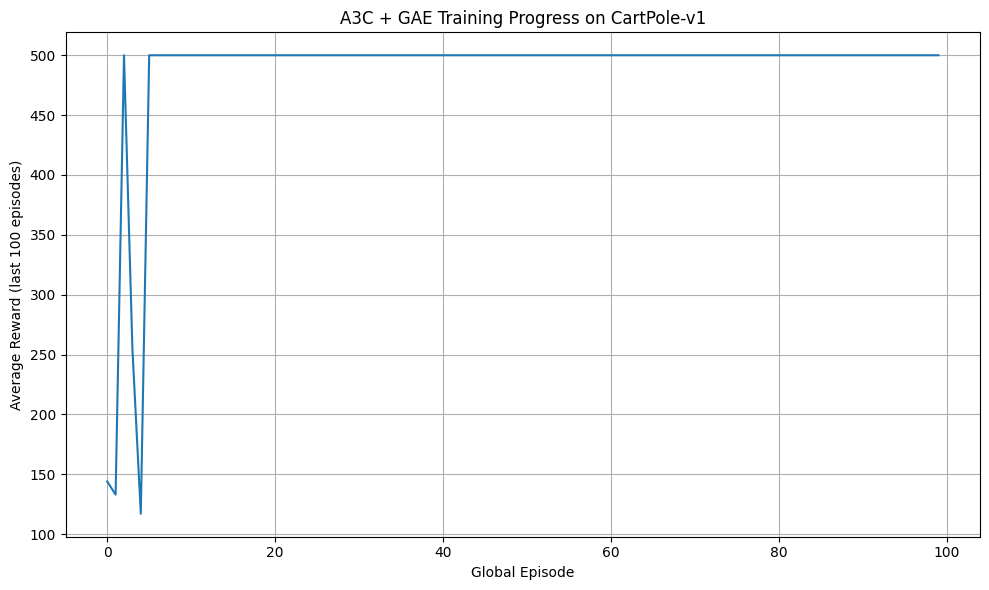

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(global_a3c.episode_rewards_deque)), list(global_a3c.episode_rewards_deque), linestyle='-')
plt.xlabel("Global Episode")
plt.ylabel(f"Average Reward (last 100 episodes)")
plt.title(f"A3C + GAE Training Progress on {ENV_NAME}")
plt.grid(True)
plt.tight_layout()
plt.show()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
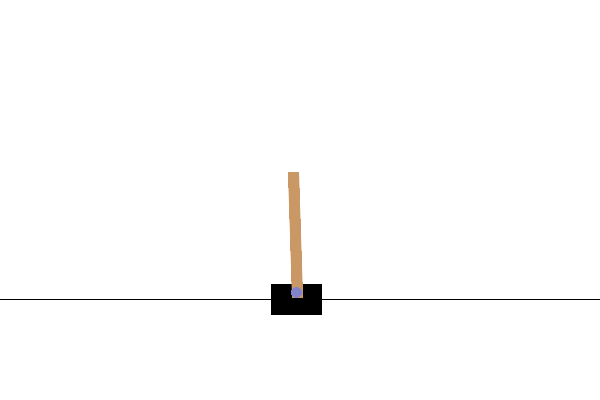

In [22]:
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
eval_env.reset()
eval_env.render()

In [23]:
# @title
eval_rewards = []
EVAL_EPISODES = 100
# Disable gradient calculations for efficiency during evaluation
with torch.no_grad():
    for episode in range(EVAL_EPISODES):
        state, _ = eval_env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not done and not truncated:
            # Get the greedy action from the global policy network
            # Move state to device if necessary (though full_pass handles it)
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device)
            logits = global_a3c.policy_net(state_tensor)
            action = torch.argmax(logits, dim=-1).item() # Select the greedy action

            next_state, reward, done, truncated, _ = eval_env.step(action)
            episode_reward += reward
            state = next_state

        eval_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"Evaluation Episode {episode+1}/{EVAL_EPISODES}: Reward = {episode_reward}")

# Close the evaluation environment
eval_env.close()

Evaluation Episode 1/100: Reward = 500.0
Evaluation Episode 11/100: Reward = 500.0
Evaluation Episode 21/100: Reward = 500.0
Evaluation Episode 31/100: Reward = 500.0
Evaluation Episode 41/100: Reward = 500.0
Evaluation Episode 51/100: Reward = 500.0
Evaluation Episode 61/100: Reward = 500.0
Evaluation Episode 71/100: Reward = 500.0
Evaluation Episode 81/100: Reward = 500.0
Evaluation Episode 91/100: Reward = 500.0



--- Evaluation Complete ---
Average Reward over 100 episodes: 500.00
Standard Deviation of Reward: 0.00
Congratulations! CartPole-v1 is considered SOLVED (Avg Reward >= 475)!


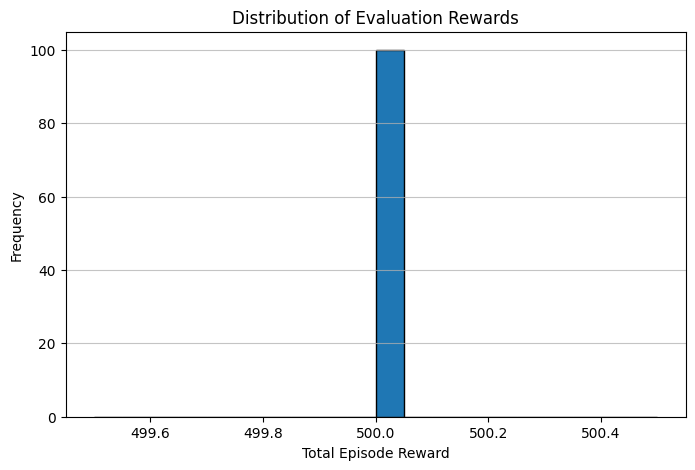

In [24]:
avg_eval_reward = np.mean(eval_rewards)
std_eval_reward = np.std(eval_rewards)

print(f"\n--- Evaluation Complete ---")
print(f"Average Reward over {EVAL_EPISODES} episodes: {avg_eval_reward:.2f}")
print(f"Standard Deviation of Reward: {std_eval_reward:.2f}")
# Check if the environment is "solved" based on its criteria (CartPole-v1: 475)
if ENV_NAME == 'CartPole-v1':
    if avg_eval_reward >= 475:
        print(f"Congratulations! {ENV_NAME} is considered SOLVED (Avg Reward >= 475)!")
    else:
        print(f"{ENV_NAME} is not yet solved (Avg Reward < 475). Keep training!")

# Optional: Plot the distribution of evaluation rewards
plt.figure(figsize=(8, 5))
plt.hist(eval_rewards, bins=20, edgecolor='black')
plt.title('Distribution of Evaluation Rewards')
plt.xlabel('Total Episode Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()